In [8]:
import cv2
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import swing3dify.time_adjustment as ta
from swing3dify.core import compute_camera_parameters, reconstruct_3D
from swing3dify.visualizations import draw_feature_matches, visualize_3d_points, draw_epipolar_lines, plot_3d_points
from calibration_data import KNOWN_CALIBRATION_DATA

In [3]:
club1 = pd.read_csv('../data/club/data/red_0712_0016/position_data.csv')
club2 = pd.read_csv('../data/club/data/white_0712_0016/position_data.csv')

In [4]:
pose1 = pd.read_csv('../data/pose/data/red_0712_0016/position_data.csv')
pose2 = pd.read_csv('../data/pose/data/white_0712_0016/position_data.csv')

In [5]:
delay_frame = ta.calculate_delay_frame(club1, club2, 'HOSEL')
print(f'delay_frame: {delay_frame}')

delay_frame: -32


In [14]:
club1_min = club1.index.min()
club1_max = club1.index.max()
club2_min = club2.index.min() + delay_frame
club2_max = club2.index.max() + delay_frame

min_index = max(club1_min, club2_min)
max_index = min(club1_max, club2_max)
print(f'min_index: {min_index}, max_index: {max_index}')

min_index: 0, max_index: 630


In [29]:
df1 = pose1.merge(club1, on='frame')
df2 = pose2.merge(club2, on='frame')

In [31]:
df2 = df2.iloc[min_index-delay_frame:max_index-delay_frame].copy()
df2.reset_index(drop=True, inplace=True)

,frame,NOSE_x,NOSE_y,LEFT_EYE_x,LEFT_EYE_y,RIGHT_EYE_x,RIGHT_EYE_y,LEFT_EAR_x,LEFT_EAR_y,RIGHT_EAR_x,RIGHT_EAR_y,LEFT_SHOULDER_x,LEFT_SHOULDER_y,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,LEFT_ELBOW_x,LEFT_ELBOW_y,RIGHT_ELBOW_x,RIGHT_ELBOW_y,LEFT_WRIST_x,LEFT_WRIST_y,RIGHT_WRIST_x,RIGHT_WRIST_y,LEFT_HIP_x,LEFT_HIP_y,RIGHT_HIP_x,RIGHT_HIP_y,LEFT_KNEE_x,LEFT_KNEE_y,RIGHT_KNEE_x,RIGHT_KNEE_y,LEFT_ANKLE_x,LEFT_ANKLE_y,RIGHT_ANKLE_x,RIGHT_ANKLE_y,BOX_x,BOX_y,BOX_width,BOX_height,TOE_x,TOE_y,HOSEL_x,HOSEL_y,GRIP_x,GRIP_y
0,65.0,0.477873,0.579988,0.483843,0.576014,0.472492,0.575605,0.486284,0.572507,0.460812,0.572339,0.481285,0.587396,0.444639,0.588598,0.481964,0.618998,0.465633,0.621092,0.480459,0.650804,0.484938,0.647127,0.450119,0.641038,0.420651,0.642085,0.465707,0.688393,0.410976,0.691334,0.479063,0.734000,0.399246,0.740639,0.578241,0.714583,0.156481,0.088542,0.657922,0.757339,0.635992,0.758800,0.499439,0.670857
1,66.0,0.478002,0.579777,0.484008,0.575810,0.472593,0.575389,0.486380,0.572459,0.460800,0.572264,0.481151,0.587512,0.444532,0.588754,0.481867,0.619001,0.465454,0.621149,0.480304,0.650755,0.484728,0.647002,0.450311,0.641046,0.420830,0.642132,0.465884,0.688421,0.410986,0.691457,0.479110,0.733917,0.399022,0.740739,0.578241,0.714583,0.156481,0.088542,0.657901,0.757313,0.635967,0.758778,0.499413,0.670852
2,67.0,0.477702,0.579878,0.483752,0.575906,0.472324,0.575489,0.486314,0.572501,0.460655,0.572327,0.481308,0.587474,0.444344,0.588771,0.481857,0.618911,0.465158,0.621136,0.480403,0.650745,0.484442,0.646869,0.450534,0.641076,0.420856,0.642192,0.465976,0.688399,0.410957,0.691494,0.479087,0.733810,0.399212,0.740697,0.578241,0.714583,0.156481,0.088542,0.657822,0.757336,0.635860,0.758811,0.499314,0.670848
3,68.0,0.477266,0.580062,0.483323,0.576083,0.471982,0.575688,0.486231,0.572522,0.460701,0.572408,0.481513,0.587317,0.444734,0.588619,0.481898,0.618834,0.465550,0.621100,0.480274,0.650728,0.484837,0.647077,0.450298,0.640907,0.420727,0.641989,0.465796,0.688262,0.410895,0.691273,0.479281,0.733774,0.399276,0.740494,0.578241,0.714583,0.156481,0.088542,0.657926,0.757311,0.635936,0.758800,0.499300,0.670879
4,69.0,0.477241,0.580036,0.483211,0.576070,0.471982,0.575688,0.486048,0.572523,0.460799,0.572433,0.481510,0.587364,0.444983,0.588598,0.482031,0.618923,0.465827,0.621018,0.480344,0.650774,0.485160,0.647091,0.450261,0.640995,0.420847,0.642025,0.465679,0.688393,0.410910,0.691290,0.479381,0.733952,0.399318,0.740485,0.578241,0.714583,0.156481,0.088542,0.657899,0.757335,0.635842,0.758877,0.499275,0.670859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,658.0,0.494509,0.571409,0.488380,0.567608,0.492842,0.568408,0.462363,0.567645,0.490747,0.569807,0.442924,0.583965,0.486327,0.589164,0.423314,0.601602,0.489822,0.620424,0.440208,0.603528,0.501357,0.642170,0.441815,0.640537,0.466846,0.643204,0.471616,0.687140,0.455601,0.688698,0.477758,0.732749,0.430082,0.733879,0.587963,0.677344,0.153704,0.056771,0.664822,0.698163,0.644417,0.709048,0.509603,0.649398
594,659.0,0.494224,0.571588,0.487993,0.567771,0.492499,0.568598,0.461946,0.567704,0.490303,0.569899,0.442679,0.583681,0.486038,0.589100,0.422393,0.600416,0.490308,0.620579,0.438390,0.600767,0.502395,0.642350,0.441481,0.640456,0.466507,0.643166,0.471223,0.687110,0.456120,0.688632,0.476178,0.732658,0.430433,0.733632,0.588426,0.677344,0.154630,0.056771,0.665393,0.698056,0.645082,0.708942,0.509649,0.649515
595,660.0,0.494366,0.571451,0.488114,0.567636,0.492645,0.568452,0.461899,0.567651,0.490245,0.569820,0.442546,0.583939,0.485907,0.589192,0.422945,0.601544,0.490147,0.620740,0.439489,0.603398,0.502772,0.642976,0.441408,0.640599,0.466449,0.643281,0.471342,0.687211,0.456159,0.688725,0.476571,0.732713,0.430409,0.733743,0.588426,0.677344,0.154630,0.056771,0.665734,0.697875,0.645366,0.708941,0.509712,0.649569
596,661.0,0.493987,0.571453,0.487660,0.567653,0.492393,0.568477,0.46141

In [35]:
height, width = 1920, 1080

for c in df1.columns[1::2]:
    df1[c] = df1[c] * width
    df2[c] = df2[c] * width
for c in df1.columns[2::2]:
    df1[c] = df1[c] * height
    df2[c] = df2[c] * height

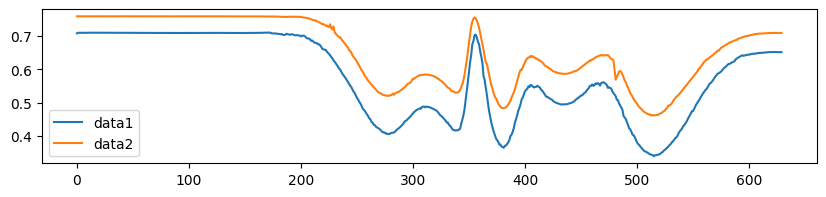

In [24]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(list(range(len(df1))), df1['HOSEL_y'], label='data1')
ax.plot(list(range(len(df2))), df2['HOSEL_y'], label='data2')
ax.legend()
plt.show()

In [ ]:
for frame in df1.index:
    pts1 = np.float32(df1.iloc[frame, 1:].values)
    pts2 = np.float32(df2.iloc[frame-delay_frame, 1:].values)

In [39]:
frame = 0
pts1 = np.float32(df1.iloc[frame, 1:].values)
pts2 = np.float32(df2.iloc[frame-delay_frame, 1:].values)

reconstructed_3d = reconstruct_3D(pts1, pts2, K, R, T)

In [40]:
pts1

array([ 575.08386 ,  921.22833 ,  582.4331  ,  912.0108  ,  567.45056 ,
        912.4658  ,  597.8551  ,  903.6191  ,  557.30835 ,  905.1636  ,
        616.4794  ,  936.2707  ,  551.2213  ,  936.984   ,  619.9866  ,
       1014.57513 ,  561.8974  , 1015.7019  ,  599.52466 , 1079.9396  ,
        588.8583  , 1083.3064  ,  611.41614 , 1050.5149  ,  560.43146 ,
       1051.238   ,  629.211   , 1163.4574  ,  534.1591  , 1163.4147  ,
        648.11993 , 1269.2037  ,  512.4726  , 1267.5728  ,  602.      ,
       1250.5     ,   13.999999,  247.      ,  608.05664 , 1377.5802  ,
        606.8018  , 1359.1315  ,  594.8518  , 1124.992   ], dtype=float32)